# Sentiment Analysis with ParsBERT

## The NVIDIA System Management Interface (nvidia-smi) is a command line utility, based on top of the NVIDIA Management Library (NVML), intended to aid in the management and monitoring of NVIDIA GPU devices.

In [ ]:
!nvidia-smi

Wed Jun 15 19:47:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    31W /  70W |   5634MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install & import Libraries

In [1]:
!pip install -q transformers
!pip install -q hazm
!pip install -q clean-text[gpl]

     |████████████████████████████████| 4.4 MB 5.4 MB/s 
     |████████████████████████████████| 596 kB 66.0 MB/s 
     |████████████████████████████████| 86 kB 6.2 MB/s 
     |████████████████████████████████| 6.6 MB 60.5 MB/s 
     |████████████████████████████████| 316 kB 5.3 MB/s 
     |████████████████████████████████| 233 kB 53.5 MB/s 
     |████████████████████████████████| 1.4 MB 10.2 MB/s 
     |████████████████████████████████| 175 kB 5.1 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 235 kB 47.4 MB/s 


In [ ]:
# Import required packages (If You Need Any More Packages, You Can Add them HERE.)

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import plotly.graph_objects as go

from tqdm.notebook import tqdm

import os
import re
import collections

from cleantext import clean
import hazm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

## Dataset

### Load the data

In [ ]:
!git clone https://github.com/SBU-CE/Deep-Learning.git
data = pd.read_csv('/content/Deep-Learning/spring-2022/assignments/project-3/taghche_5000.csv', encoding='utf-8')
data = data[['comment', 'rate']]
data.head()

fatal: destination path 'Deep-Learning' already exists and is not an empty directory.


,comment,rate
0,اسم کتاب No one writes to the Colonel\nترجمش...,0
1,"طاقچه عزیز،نام کتاب""کسی به سرهنگ نامه نمینویسد...",5
2,بنظرم این اثر مارکز خیلی از صد سال تنهایی که ب...,5
3,به نظر کتاب خوبی میومد اما من از ترجمش خوشم نی...,2
4,کتاب خوبی است,3


In [ ]:
# handle some conflicts with the dataset structure
# you can find a reliable solution, for the sake of the simplicity
# I just remove these bad combinations!
data['rate'] = data['rate'].apply(lambda r: r if r < 6 else None)

data = data.dropna(subset=['rate'])
data = data.dropna(subset=['comment'])
data = data.drop_duplicates(subset=['comment'], keep='first')
data = data.reset_index(drop=True)

### Normalization / Preprocessing

**<font color=red> For simplicity, Transform the rate in a range of 0.0 to 5.0 to a binary form of negative (0) or positive (1) with a threshold. If the rate is less than 3.0, it labeled as negative otherwise specified as positive.</font>**

In [ ]:
##############################################################################################
#                                       Your Code                                            #


threshold = 3.0
data_rate_size = data['rate'].shape[0]

data['label'] = [None] * data_rate_size

for i in range(data_rate_size):
  if data['rate'][i] < threshold:
    data['label'][i] = 'negative'
  else:
    data['label'][i] = 'positive'

labels = list(sorted(data['label'].unique()))

data.head()

##############################################################################################

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,comment,rate,label
0,اسم کتاب No one writes to the Colonel\nترجمش...,0,negative
1,"طاقچه عزیز،نام کتاب""کسی به سرهنگ نامه نمینویسد...",5,positive
2,بنظرم این اثر مارکز خیلی از صد سال تنهایی که ب...,5,positive
3,به نظر کتاب خوبی میومد اما من از ترجمش خوشم نی...,2,negative
4,کتاب خوبی است,3,positive


**<font color=red> Cleaning is the final step in this section. Your cleaned method should be included these steps:</font>**

**<font color=red>- fixing unicodes</font>**

**<font color=red>- removing specials like a phone number, email, url, new lines, ...</font>**

**<font color=red>- cleaning HTMLs</font>**

**<font color=red>- normalizing</font>**

**<font color=red>- removing emojis</font>**

**<font color=red>- removing extra spaces, hashtags</font>**

In [ ]:
def cleanhtml(raw_html):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', raw_html)
  return cleantext


def cleaning(text):
    text = text.strip()

    ##############################################################################################
    #                                       Your Code                                            #

    # regular cleaning
    text = clean(text,
        fix_unicode=True,
        to_ascii=False,
        lower=True,
        no_line_breaks=True,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=False,
        no_digits=False,
        no_currency_symbols=True,
        no_punct=False,
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="0",
        replace_with_currency_symbol=""
    )

    # cleaning htmls
    text = cleanhtml(text)
    
    # normalizing
    normalizer = hazm.Normalizer()
    text = normalizer.normalize(text)
    
    # removing wierd patterns
    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        # u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)
    
    text = wierd_pattern.sub(r'', text)
    
    # removing extra spaces, hashtags
    text = re.sub("#", "", text)
    text = re.sub("\s+", " ", text)
    
    ##############################################################################################
    
    
    return text

In [ ]:
# cleaning comments
data['cleaned_comment'] = data['comment'].apply(cleaning)

**<font color=red> Calculate the Length of Comments based on their Words</font>**

In [ ]:
##############################################################################################
#                                       Your Code                                            #

data['comment_len_by_words'] = data['comment'].apply(lambda t: len(hazm.word_tokenize(t)))

##############################################################################################

**<font color=red> Remove Comments with the Length of Fewer than 3 Words & More than 256 Words</font>**

In [ ]:
##############################################################################################
#                                       Your Code                                            #

min_limit = 3
max_limit = 256

data['comment_len_by_words'] = data['comment_len_by_words'].apply(lambda len_t: len_t if min_limit < len_t <= max_limit else None)
data = data.dropna(subset=['comment_len_by_words'])
data = data.reset_index(drop=True)

##############################################################################################

In [ ]:
data = data[['cleaned_comment', 'label']]
data.columns = ['comment', 'label']
data.head()

,comment,label
0,اسم کتاب no one writes to the colonel ترجمش می...,negative
1,طاقچه عزیز، نام کتاب «کسی به سرهنگ نامه نمینوی...,positive
2,بنظرم این اثر مارکز خیلی از صد سال تنهایی که ب...,positive
3,به نظر کتاب خوبی میومد اما من از ترجمش خوشم نی...,negative
4,راستش خیلی خوشم نیومد ازش!,positive


### Handling Unbalanced Data

**<font color=red> Because the Data is Unbalanced, You should Balance it. Before & After Balancing Data, You should Plot a Bar Chart of Distribution of label within comments [DATA]</font>**

In [ ]:
##############################################################################################
#                                       Your Code                                            #
fig = go.Figure()
groupby_label = data.groupby('label')['label'].count()


fig.add_trace(go.Bar(
    x=list(sorted(groupby_label.index)),
    y=groupby_label.tolist(),
    text=groupby_label.tolist(),
    textposition='auto'
))


fig.update_layout(
    title_text='Distribution of label within comments [DATA]',
    xaxis_title_text='Label',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()


negative_data = data[data['label'] == 'negative']
positive_data = data[data['label'] == 'positive']

cutting_point = min(len(negative_data), len(positive_data))

if cutting_point <= len(negative_data):
    negative_data = negative_data.sample(n=cutting_point).reset_index(drop=True)

if cutting_point <= len(positive_data):
    positive_data = positive_data.sample(n=cutting_point).reset_index(drop=True)

new_data = pd.concat([negative_data, positive_data])
new_data = new_data.sample(frac=1).reset_index(drop=True)


fig = go.Figure()
groupby_label = new_data.groupby('label')['label'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_label.index)),
    y=groupby_label.tolist(),
    text=groupby_label.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of label within comments [NEW DATA]',
    xaxis_title_text='Label',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()
##############################################################################################

## Train,Validation,Test split

To achieve a globalized model, we need to split the cleaned dataset into train, valid, test sets due to size of the data. In this tutorial, I have considered a rate of **0.1** for both *valid*, *test* sets. For splitting, I use `train_test_split` provided by Sklearn package with stratifying on the label for preserving the distribution balance.

In [ ]:
new_data['label_id'] = new_data['label'].apply(lambda t: labels.index(t))

train, test = train_test_split(new_data, test_size=0.1, random_state=1, stratify=new_data['label'])
train, valid = train_test_split(train, test_size=0.1, random_state=1, stratify=train['label'])

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

x_train, y_train = train['comment'].values.tolist(), train['label_id'].values.tolist()
x_valid, y_valid = valid['comment'].values.tolist(), valid['label_id'].values.tolist()
x_test, y_test = test['comment'].values.tolist(), test['label_id'].values.tolist()

print(train.shape)
print(valid.shape)
print(test.shape)

(1245, 3)
(139, 3)
(154, 3)


![BERT INPUTS](https://res.cloudinary.com/m3hrdadfi/image/upload/v1595158991/kaggle/bert_inputs_w8rith.png)

As you may know, the BERT model input is a combination of 3 embeddings.
- Token embeddings: WordPiece token vocabulary (WordPiece is another word segmentation algorithm, similar to BPE)
- Segment embeddings: for pair sentences [A-B] marked as $E_A$ or $E_B$ mean that it belongs to the first sentence or the second one.
- Position embeddings: specify the position of words in a sentence

## PyTorch

In [ ]:
# Import required packages (If You Need Any More Packages, You Can Add them HERE.)

import torch
import torch.nn as nn
import torch.nn.functional as F

from transformers import BertConfig, BertTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

### Configuration

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device: cuda:0
CUDA is available!  Training on GPU ...


In [ ]:
# general config
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16

EPOCHS = 10
EEVERY_EPOCH = 1000
LEARNING_RATE = 2e-5
CLIP = 0.0

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = '/content/bert-fa-base-uncased-sentiment-taaghceh/pytorch_model.bin'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [ ]:
# create a key finder based on label 2 id and id to label

label2id = {label: i for i, label in enumerate(labels)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

label2id: {'negative': 0, 'positive': 1}
id2label: {0: 'negative', 1: 'positive'}


**<font color=red> Setup the Tokenizer and Configuration</font>**

In [ ]:
##############################################################################################
#                                       Your Code                                            #
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = BertConfig.from_pretrained(
    MODEL_NAME_OR_PATH, **{
        'label2id': label2id,
        'id2label': id2label,
    })
##############################################################################################

### Input Embeddings

### Dataset

In [ ]:
class TaaghcheDataset(torch.utils.data.Dataset):
    """ Create a PyTorch dataset for Taaghche. """

    def __init__(self, tokenizer, comments, targets=None, label_list=None, max_len=128):
        self.comments = comments
        self.targets = targets
        self.has_target = isinstance(targets, list) or isinstance(targets, np.ndarray)

        self.tokenizer = tokenizer
        self.max_len = max_len

        
        self.label_map = {label: i for i, label in enumerate(label_list)} if isinstance(label_list, list) else {}
    
    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])

        if self.has_target:
            target = self.label_map.get(str(self.targets[item]), str(self.targets[item]))

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')
        
        inputs = {
            'comment': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
        }

        if self.has_target:
            inputs['targets'] = torch.tensor(target, dtype=torch.long)
        
        return inputs


def create_data_loader(x, y, tokenizer, max_len, batch_size, label_list):
    dataset = TaaghcheDataset(
        comments=x,
        targets=y,
        tokenizer=tokenizer,
        max_len=max_len, 
        label_list=label_list)
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [ ]:
label_list = ['negative', 'positive']
train_data_loader = create_data_loader(train['comment'].to_numpy(), train['label'].to_numpy(), tokenizer, MAX_LEN, TRAIN_BATCH_SIZE, label_list)
valid_data_loader = create_data_loader(valid['comment'].to_numpy(), valid['label'].to_numpy(), tokenizer, MAX_LEN, VALID_BATCH_SIZE, label_list)
test_data_loader = create_data_loader(test['comment'].to_numpy(), None, tokenizer, MAX_LEN, TEST_BATCH_SIZE, label_list)

### Model

**<font color=red> Complete forward function</font>**

In [ ]:
class SentimentModel(nn.Module):

    def __init__(self, config):
        super(SentimentModel, self).__init__()

        self.bert = BertModel.from_pretrained(MODEL_NAME_OR_PATH)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        ##############################################################################################
        #                                       Your Code                                            #
        _, pooled_output = self.bert(
        input_ids=input_ids, 
        attention_mask=attention_mask, 
        token_type_ids=token_type_ids, return_dict=False)
        
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        ##############################################################################################
        return logits 

In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
pt_model = None

!nvidia-smi

Wed Jun 15 19:47:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    33W /  70W |   4046MiB / 15109MiB |     34%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pt_model = SentimentModel(config=config)
pt_model = pt_model.to(device)

print('pt_model', type(pt_model))

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


pt_model <class '__main__.SentimentModel'>


### Training

**<font color=red> Complete functions</font>**

In [ ]:
def acc_and_f1(y_true, y_pred, average='weighted'):
    # Define Accuracy and F1-score
    ##############################################################################################
    #                                       Your Code                                            #
    acc = (y_true == y_pred).mean()
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average=average)
    ##############################################################################################
    return {
        "acc": acc,
        "f1": f1,
    }

def y_loss(y_true, y_pred, losses):
    y_true = torch.stack(y_true).cpu().detach().numpy()
    y_pred = torch.stack(y_pred).cpu().detach().numpy()
    y = [y_true, y_pred]
    loss = np.mean(losses)

    return y, loss


def eval_op(model, data_loader, loss_fn):
    model.eval()

    losses = []
    y_pred = []
    y_true = []

    with torch.no_grad():
        for dl in tqdm(data_loader, total=len(data_loader), desc="Evaluation... "):

            # Define input_ids, attention_mask, token_type_ids, targets
            ##############################################################################################
            #                                       Your Code                                            #
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']
            targets = dl['targets']
            ##############################################################################################


            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            targets = targets.to(device)

            # compute predicted outputs by passing inputs to the model
            ##############################################################################################
            #                                       Your Code                                            #
            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)
            ##############################################################################################
            
            # convert output probabilities to predicted class
            ##############################################################################################
            #                                       Your Code                                            #
            _, preds = torch.max(outputs, dim=1)
            ##############################################################################################

            # calculate the batch loss
            ##############################################################################################
            #                                       Your Code                                            #
            loss = loss_fn(outputs, targets)
            ##############################################################################################

            # accumulate all the losses
            losses.append(loss.item())

            y_pred.extend(preds)
            y_true.extend(targets)
    
    eval_y, eval_loss = y_loss(y_true, y_pred, losses)
    return eval_y, eval_loss


def train_op(model, 
             data_loader, 
             loss_fn, 
             optimizer, 
             scheduler, 
             step=0, 
             print_every_step=100, 
             eval=False,
             eval_cb=None,
             eval_loss_min=np.Inf,
             eval_data_loader=None, 
             clip=0.0):
    
    model.train()

    losses = []
    y_pred = []
    y_true = []

    for dl in tqdm(data_loader, total=len(data_loader), desc="Training... "):
        step += 1

        # Define input_ids, attention_mask, token_type_ids, targets
        ##############################################################################################
        #                                       Your Code                                            #
        input_ids = dl['input_ids']
        attention_mask = dl['attention_mask']
        token_type_ids = dl['token_type_ids']
        targets = dl['targets']
        ##############################################################################################

        # move tensors to GPU if CUDA is available
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        targets = targets.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # compute predicted outputs by passing inputs to the model
        ##############################################################################################
        #                                       Your Code                                            #
        outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids)
        ##############################################################################################
        
        # convert output probabilities to predicted class
        ##############################################################################################
        #                                       Your Code                                            #
        _, preds = torch.max(outputs, dim=1)
        ##############################################################################################

        # calculate the batch loss
        ##############################################################################################
        #                                       Your Code                                            #
        loss = loss_fn(outputs, targets)
        ##############################################################################################

        # accumulate all the losses
        losses.append(loss.item())

        # compute gradient of the loss with respect to model parameters
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        if clip > 0.0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

        # perform optimization step
        optimizer.step()

        # perform scheduler step
        scheduler.step()

        y_pred.extend(preds)
        y_true.extend(targets)

        if eval:
            train_y, train_loss = y_loss(y_true, y_pred, losses)
            train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')

            if step % print_every_step == 0:
                eval_y, eval_loss = eval_op(model, eval_data_loader, loss_fn)
                eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')

                if hasattr(eval_cb, '__call__'):
                    eval_loss_min = eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min)

    train_y, train_loss = y_loss(y_true, y_pred, losses)

    return train_y, train_loss, step, eval_loss_min

**<font color=red> Define Optimizer, Scheduler & Loss Function</font>**

In [ ]:
#######################################Your Code#############################################

optimizer = AdamW(pt_model.parameters(), lr=LEARNING_RATE, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()                              
                                                
##############################################################################################

step = 0
eval_loss_min = np.Inf
history = collections.defaultdict(list)


def eval_callback(epoch, epochs, output_path):
    def eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min):
        statement = ''
        statement += 'Epoch: {}/{}...'.format(epoch, epochs)
        statement += 'Step: {}...'.format(step)
        
        statement += 'Train Loss: {:.6f}...'.format(train_loss)
        statement += 'Train Acc: {:.3f}...'.format(train_score['acc'])

        statement += 'Valid Loss: {:.6f}...'.format(eval_loss)
        statement += 'Valid Acc: {:.3f}...'.format(eval_score['acc'])

        print(statement)

        if eval_loss <= eval_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                eval_loss_min,
                eval_loss))
            
            torch.save(model.state_dict(), output_path)
            eval_loss_min = eval_loss
        
        return eval_loss_min


    return eval_cb

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



**<font color=red> Complete Training & Plot Loss and Accuracy Diagram</font>**

Epochs... :   0%|          | 0/10 [00:00<?, ?it/s]

Training... :   0%|          | 0/78 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/9 [00:00<?, ?it/s]

Training... :   0%|          | 0/78 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/9 [00:00<?, ?it/s]

Training... :   0%|          | 0/78 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/9 [00:00<?, ?it/s]

Training... :   0%|          | 0/78 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/9 [00:00<?, ?it/s]

Training... :   0%|          | 0/78 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/9 [00:00<?, ?it/s]

Training... :   0%|          | 0/78 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/9 [00:00<?, ?it/s]

Training... :   0%|          | 0/78 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/9 [00:00<?, ?it/s]

Training... :   0%|          | 0/78 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/9 [00:00<?, ?it/s]

Training... :   0%|          | 0/78 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/9 [00:00<?, ?it/s]

Training... :   0%|          | 0/78 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/9 [00:00<?, ?it/s]

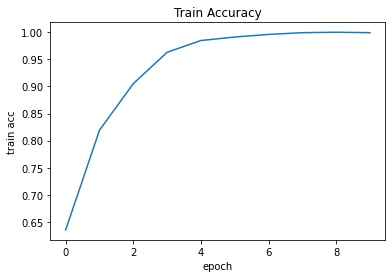

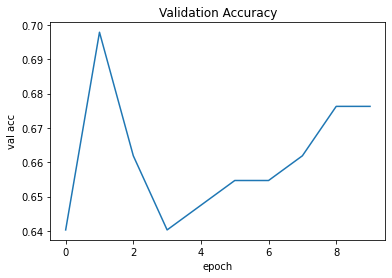

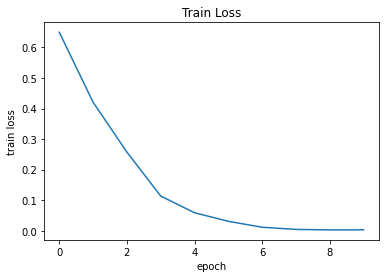

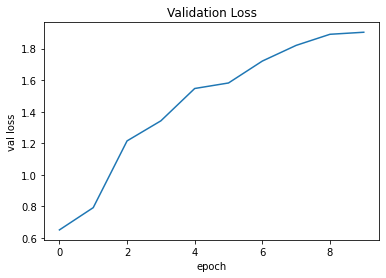

In [ ]:
for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs... "):

    # Define train_y, train_loss, step, eval_loss_min using train_op
    ##############################################################################################
    #                                       Your Code                                            #
    train_y, train_loss, step, eval_loss_min = train_op(
    model=pt_model, 
    data_loader=train_data_loader, 
    loss_fn=loss_fn, 
    optimizer=optimizer, 
    scheduler=scheduler, 
    step=step, 
    print_every_step=EEVERY_EPOCH, 
    eval=True,
    eval_cb=eval_callback(epoch, EPOCHS, OUTPUT_PATH),
    eval_loss_min=eval_loss_min,
    eval_data_loader=valid_data_loader, 
    clip=CLIP)
    ##############################################################################################
    
    # Define train_score using acc_and_f1
    ##############################################################################################
    #                                       Your Code                                            #
    train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')
    ##############################################################################################
    
    # Define eval_y, eval_loss using eval_op
    ##############################################################################################
    #                                       Your Code                                            #
    eval_y, eval_loss = eval_op(
    model=pt_model, 
    data_loader=valid_data_loader, 
    loss_fn=loss_fn)
    ##############################################################################################
    
    # Define eval_score using acc_and_f1
    ##############################################################################################
    #                                       Your Code                                            #
    eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')
    ##############################################################################################
    
    # Save Accuracy and Loss values
    ##############################################################################################
    #                                       Your Code                                            #
    history['train_acc'].append(train_score['acc'])
    history['train_loss'].append(train_loss)
    history['val_acc'].append(eval_score['acc'])
    history['val_loss'].append(eval_loss)

    # print("train_acc: ".format(train_score['acc']))
    # print("train_loss: ".format(train_score['acc']))
    # print("val_acc: ".format(train_score['acc']))
    # print("val_loss: ".format(train_score['acc']))

    ##############################################################################################


# Diagram
##############################################################################################
#                                       Your Code                                            #
plt.plot(history['train_acc'])
plt.xlabel('epoch') 
plt.ylabel('train acc') 
plt.title("Train Accuracy")
plt.show()

plt.plot(history['val_acc'])
plt.xlabel('epoch') 
plt.ylabel('val acc') 
plt.title("Validation Accuracy")
plt.show()

plt.plot(history['train_loss'])
plt.xlabel('epoch') 
plt.ylabel('train loss') 
plt.title("Train Loss")
plt.show()


plt.plot(history['val_loss'])
plt.xlabel('epoch') 
plt.ylabel('val loss') 
plt.title("Validation Loss")
plt.show()

##############################################################################################

### Prediction

**<font color=red> Complete function</font>**

In [ ]:
def predict(model, comments, tokenizer, max_len=128, batch_size=32):
    data_loader = create_data_loader(comments, None, tokenizer, max_len, batch_size, None)
    
    predictions = []
    prediction_probs = []

    
    model.eval()
    with torch.no_grad():
        for dl in tqdm(data_loader, position=0):

            # Define input_ids, attention_mask, token_type_ids
            ##############################################################################################
            #                                       Your Code                                            #
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']
            ##############################################################################################

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            
            # compute predicted outputs by passing inputs to the model
            ##############################################################################################
            #                                       Your Code                                            #
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            ##############################################################################################
            
            # convert output probabilities to predicted class
            ##############################################################################################
            #                                       Your Code                                            #
            _, preds = torch.max(outputs, dim=1)
            ##############################################################################################

            predictions.extend(preds)
            prediction_probs.extend(F.softmax(outputs, dim=1))

    predictions = torch.stack(predictions).cpu().detach().numpy()
    prediction_probs = torch.stack(prediction_probs).cpu().detach().numpy()

    return predictions, prediction_probs

In [ ]:
test_comments = test['comment'].to_numpy()
preds, probs = predict(pt_model, test_comments, tokenizer, max_len=128)

print(preds.shape, probs.shape)

  0%|          | 0/5 [00:00<?, ?it/s]

(154,) (154, 2)


**<font color=red> Evaluate Your Model using f1-score & Precision & Recall</font>**

In [ ]:
##############################################################################################
#                                       Your Code                                            #
y_test, y_pred = [label_list.index(label) for label in test['label'].values], preds

print(f'F1: {f1_score(y_test, y_pred, average="weighted")}')
print()
print(classification_report(y_test, y_pred, target_names=label_list))
##############################################################################################

F1: 0.688101265822785

              precision    recall  f1-score   support

    negative       0.68      0.71      0.70        77
    positive       0.70      0.66      0.68        77

    accuracy                           0.69       154
   macro avg       0.69      0.69      0.69       154
weighted avg       0.69      0.69      0.69       154

